In [56]:
# импорт библиотек
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

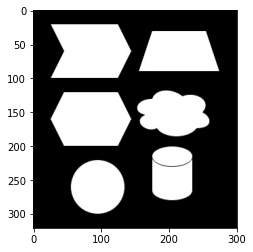

In [57]:
img = cv2.imread('/content/basic_image.jpg', 1) # загрузка изображения
plt.imshow(img) # отображение 

In [58]:
def sp(img: np.ndarray, part: float)->np.ndarray:
    random_index = (np.random.rand(img.shape[0], img.shape[1])*100).astype(np.uint8) # генерируем случаный индексы
    output = np.copy(img) # делаем глубокую копию изображения
    output[random_index<=part] = 255 # заменяем значение пиксела
    return output

In [59]:
sp50 = sp(img, 50)

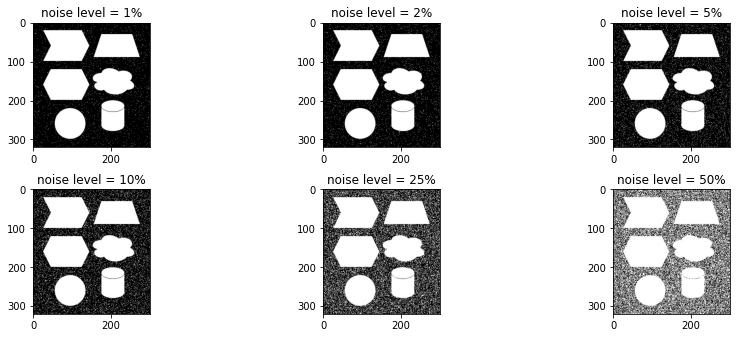

In [60]:
# Методика отображения взята из документации https://matplotlib.org/stable/gallery/lines_bars_and_markers/markevery_demo.html#sphx-glr-gallery-lines-bars-and-markers-markevery-demo-py
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]
pie = [1, 2, 5, 10, 25, 50]
rows = len(pie)
cols = 3
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, part in zip(axs, pie):
    ax.set_title(f"noise level = {part}%")
    ax.imshow(sp(img, part))

In [61]:
def erosian(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    y = kernal.shape[0] // 2
    x = kernal.shape[1] // 2
    processed_image = np.copy(img)
    for i in range(y, img.shape[0] - y):
        for j in range(x, img.shape[1] - x):
            local_window = img[i-y:i+y+1, j-x:j+x+1]
            processed_image[i][j] = np.min(local_window[kernal])
    return processed_image 

def dilate(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    y = kernal.shape[0] // 2
    x = kernal.shape[1] // 2
    processed_image = np.copy(img)
    for i in range(y, img.shape[0] - y):
        for j in range(x, img.shape[1] - x):
            local_window = img[i-y:i+y+1, j-x:j+x+1]
            processed_image[i][j] = np.max(local_window[kernal])
    return processed_image 

def opening(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    temp = erosian(img, kernal)
    output = dilate(temp, kernal)
    return output

def closing(img: np.ndarray, kernal: np.ndarray) -> np.ndarray:
    temp = dilate(img, kernal)
    output = erosian(temp, kernal)
    return output

In [62]:
structs = {
    'cross3': np.array([[False,True,False],[True,True,True],[False,True,False]], dtype=bool),
    'rect3': np.ones((3,3), dtype=bool),
    'cross5': np.array([
        [False,False,True,False,False],
        [False,False,True,False,False],
        [True]*5,
        [False,False,True,False,False],
        [False,False,True,False,False]], dtype=bool),
    'rect5': np.ones((5,5), dtype=bool)
}

In [63]:
assert (cv2.erode(img, structs['rect3'].astype(np.uint8)) == erosian(img, structs['rect3'])).all()
assert (cv2.dilate(img, structs['rect3'].astype(np.uint8)) == dilate(img, structs['rect3'])).all()

In [64]:
opers = {
    'erosian':[erosian(sp50,structs[kernel]) for kernel in structs],
    'dilate':[dilate(sp50,structs[kernel]) for kernel in structs],
    'opening':[opening(sp50,structs[kernel]) for kernel in structs],
    'close':[closing(sp50,structs[kernel]) for kernel in structs]
}

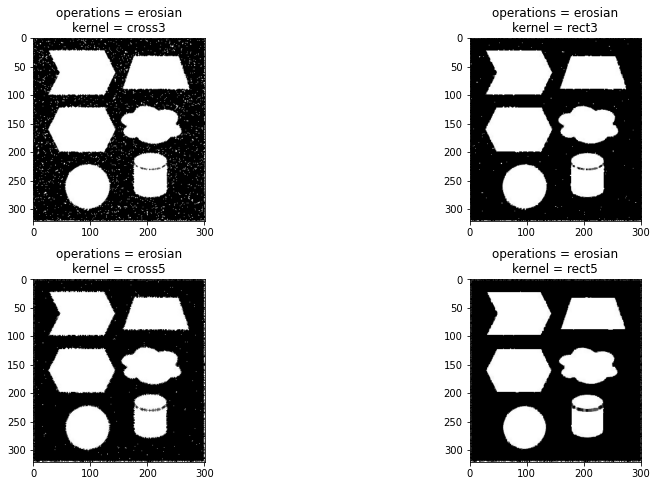

In [65]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['erosian'], structs):
    ax.set_title(f"operations = erosian\nkernel = {kernel}")
    ax.imshow(oper)

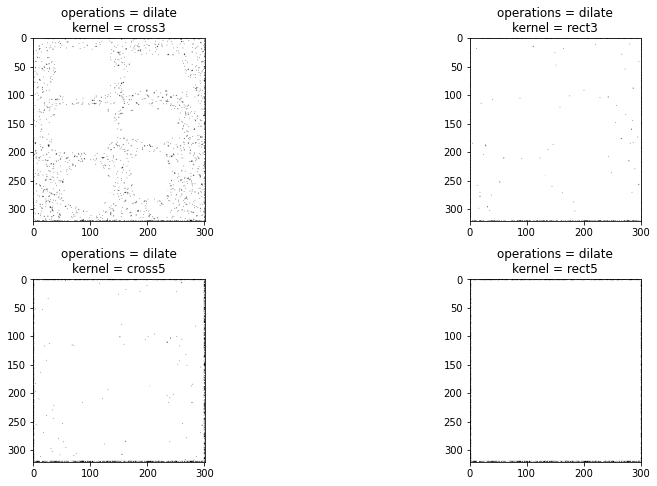

In [66]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['dilate'], structs):
    ax.set_title(f"operations = dilate\nkernel = {kernel}")
    ax.imshow(oper)

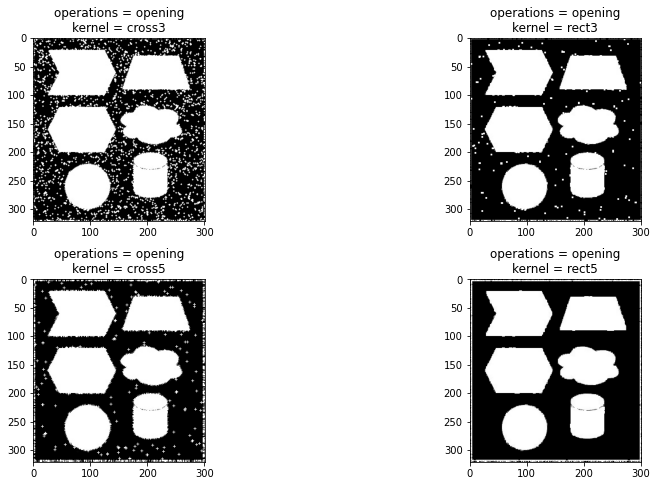

In [67]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['opening'], structs):
    ax.set_title(f"operations = opening\nkernel = {kernel}")
    ax.imshow(oper)

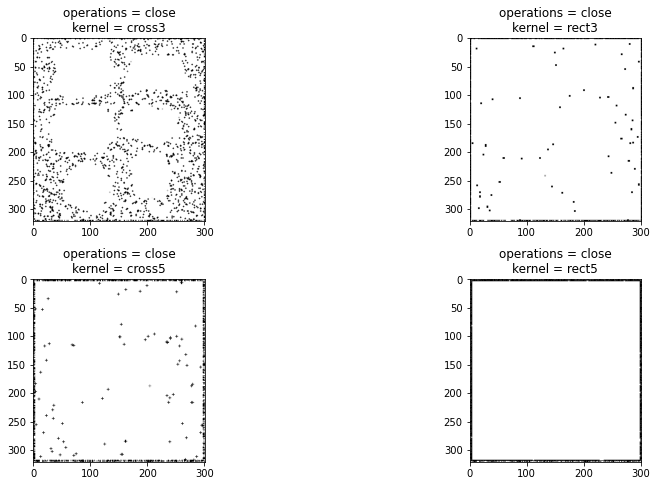

In [68]:
rows = 4
cols = 2
axs = plt.figure(figsize=(12,12), constrained_layout=True).subplots(rows, cols)
axs = trim_axs(axs, rows)
for ax, oper, kernel in zip(axs, opers['close'], structs):
    ax.set_title(f"operations = close\nkernel = {kernel}")
    ax.imshow(oper)

In [69]:
def tableFilter(img: np.ndarray, kernel: np.ndarray)->np.ndarray:
    x, y = kernel.shape[0] // 2, kernel.shape[1] // 2
    output = img.copy()
    for i in range(y, img.shape[0] - y):
        for j in range(x, img.shape[1] - x):
            local_window = img[i-y:i+y+1, j-x:j+x+1]
            temp = local_window[kernel]
            output[i][j] = np.max([temp[0],temp[1],temp[2],temp[3]]) if temp[2].all() else np.min([temp[0],temp[1],temp[2],temp[3]])
    return output

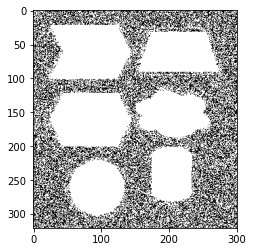

In [70]:
plt.imshow(tableFilter(sp50, structs['rect3']))

In [71]:
def custom_metric(img: np.ndarray, filtered: np.ndarray) -> float:
    metric = len(img[img != filtered]) / img.size
    return metric

In [72]:
list(structs.values())

[array([[False,  True, False],
        [ True,  True,  True],
        [False,  True, False]]), array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]), array([[False, False,  True, False, False],
        [False, False,  True, False, False],
        [ True,  True,  True,  True,  True],
        [False, False,  True, False, False],
        [False, False,  True, False, False]]), array([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]])]

In [73]:
sp_img = [sp(img, noise) for noise in pie]
def create_report():
    for index, noise in enumerate(pie):
        for kernel in structs:
    #         report[f'errosian-{noise}-{kernal}'] = {'kernal':kernel, 'noise':noise, 'metric': custom_metric(img, (erosian(sp_img[index], structs[kernel])))}
    #         report[f'dilate-{noise}-{kernal}'] = {'kernal':kernel, 'noise':noise, 'metric': custom_metric(img, (dilate(sp_img[index], structs[kernel])))}
    #         report[f'openning-{noise}-{kernal}'] = {'kernal':kernel, 'noise':noise, 'metric': custom_metric(img, (opening(sp_img[index], structs[kernel])))}
    #         report[f'closing-{noise}-{kernal}'] = {'kernal':kernel, 'noise':noise, 'metric': custom_metric(img, (closing(sp_img[index], structs[kernel])))}
    #         report[f'tablefilter-{noise}-{kernal}'] = {'kernal':kernel, 'noise':noise, 'metric': custom_metric(img, (tableFilter(sp_img[index], structs[kernel])))}
    # return report
            print(f'errosian, {kernel}, noise {noise}% metric value: {custom_metric(img, (erosian(sp_img[index], structs[kernel])))}')
            print(f'dilate, {kernel}, noise {noise}% metric value: {custom_metric(img, (dilate(sp_img[index], structs[kernel])))}')
            print(f'openning, {kernel}, noise {noise}% metric value: {custom_metric(img, (opening(sp_img[index], structs[kernel])))}')
            print(f'closing, {kernel}, noise {noise}% metric value: {custom_metric(img, (closing(sp_img[index], structs[kernel])))}')
            print(f'tablefilter, {kernel}, noise {noise}% metric value: {custom_metric(img, (tableFilter(sp_img[index], structs[kernel])))}')

In [52]:
create_report()

errosian, cross3, noise 1% metric value: 0.10115813332505356
dilate, cross3, noise 1% metric value: 0.1596236842922346
openning, cross3, noise 1% metric value: 0.05296985127456764
closing, cross3, noise 1% metric value: 0.06375425632108962
tablefilter, cross3, noise 1% metric value: 0.06559650593556267
errosian, rect3, noise 1% metric value: 0.11525444779085292
dilate, rect3, noise 1% metric value: 0.2110514277434512
openning, rect3, noise 1% metric value: 0.06671427536456878
closing, rect3, noise 1% metric value: 0.08096583558439677
tablefilter, rect3, noise 1% metric value: 0.10825803914262945
errosian, cross5, noise 1% metric value: 0.12531437265190798
dilate, cross5, noise 1% metric value: 0.2207284130779023
openning, cross5, noise 1% metric value: 0.0555572805083781
closing, cross5, noise 1% metric value: 0.07205472930315356
tablefilter, cross5, noise 1% metric value: 0.10380766086047546
errosian, rect5, noise 1% metric value: 0.14218441125635214
dilate, rect5, noise 1% metric val

Задание 3

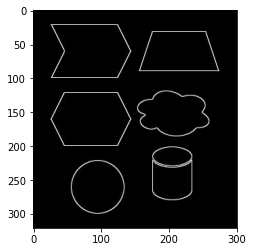

In [53]:
plt.imshow(img ^ erosian(img, structs['rect3']))

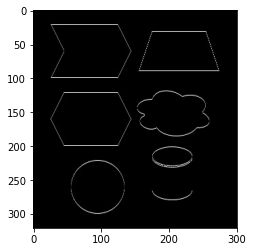

In [54]:
window = np.array([[True],[True],[True]])
plt.imshow(img ^ erosian(img, window) )

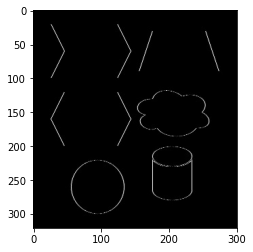

In [55]:
window = np.array([[True,True,True]])
plt.imshow(img ^ erosian(img, window) )

In [79]:
figure = np.ones((32,32), dtype=np.uint8)
figure[4:28,4:28] = 0
figure[8:24, 8:24] = 1

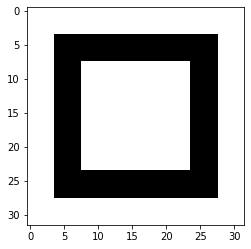

In [80]:
plt.imshow(figure, plt.cm.gray)

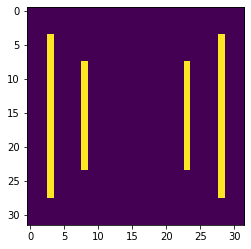

In [81]:
window = np.array([[True,True,True]])
plt.imshow(figure ^ erosian(figure, window) )

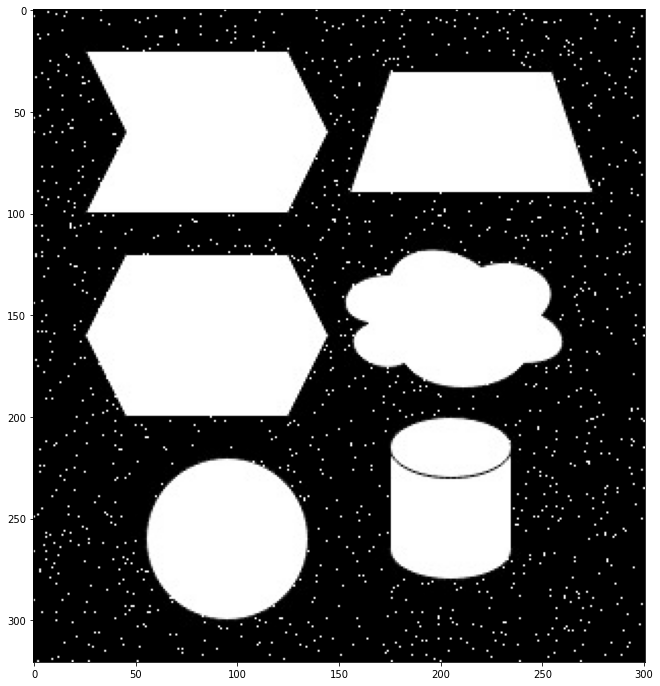

In [83]:
fig, axs = plt.subplots(1,1,figsize=(12,12))
axs.imshow(sp(img, 1))

Text(0.5, 1.0, 'My openning')

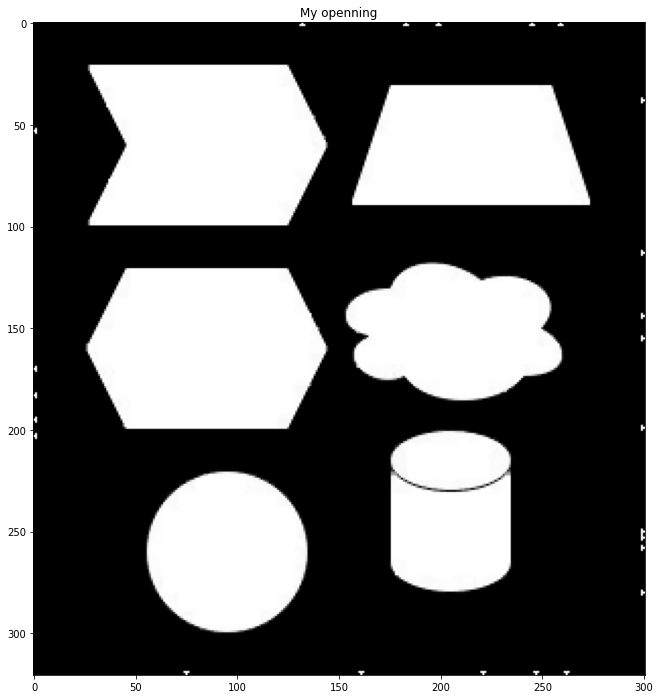

In [96]:
fig, axs = plt.subplots(1,1,figsize=(12,12))
axs.imshow(opening(sp(img, 1), structs['rect3']))
axs.set_title("My openning")

In [97]:
custom_metric(img, sp(img, 1))

0.013444282298879126

In [98]:
custom_metric(img, opening(sp(img, 1), structs['rect3']))

0.06670392564763354

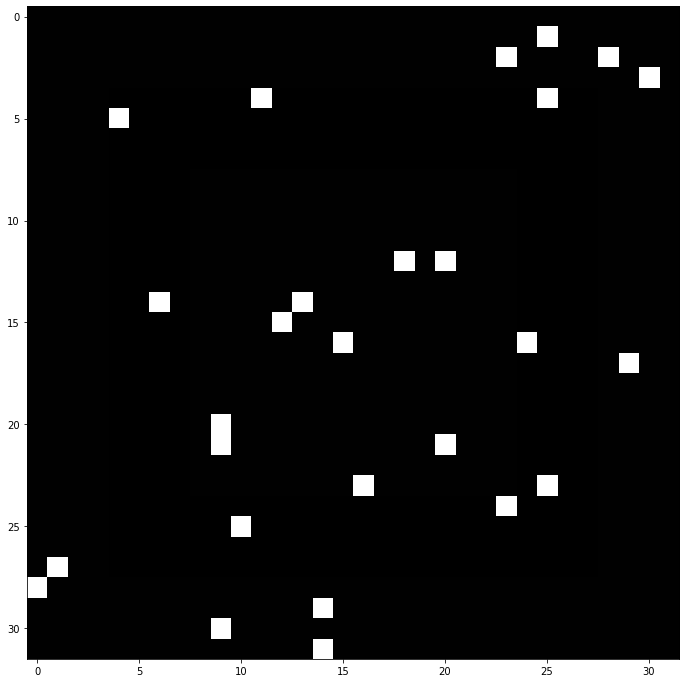

In [101]:
fig, axs = plt.subplots(1,1,figsize=(12,12))
axs.imshow(sp(figure, 1), cmap=plt.cm.gray)

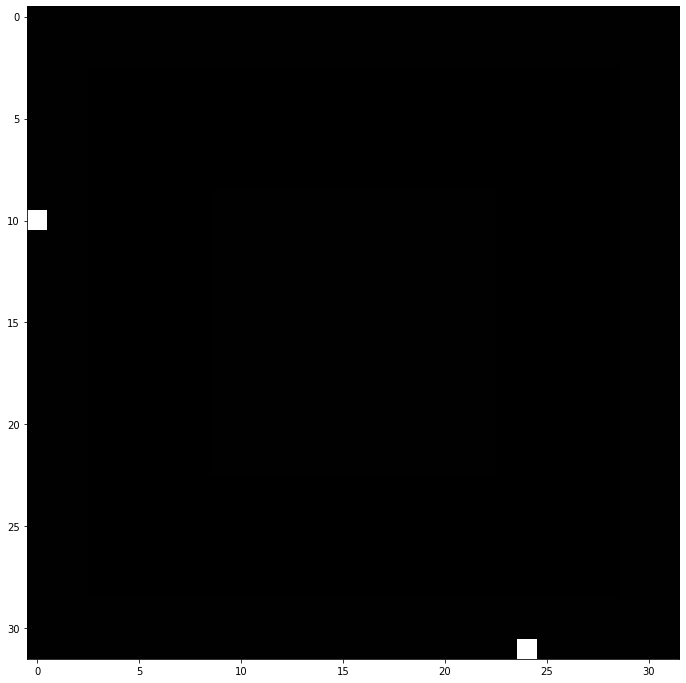

In [134]:
fig, axs = plt.subplots(1,1,figsize=(12,12))
axs.imshow(erosian(figure, 1), structs['rect3']), cmap=plt.cm.gray)

In [135]:
temp = erosian(sp(figure, 1), structs['rect3'])

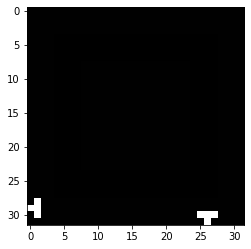

In [136]:
plt.imshow(dilate(temp, structs['rect3']), cmap=plt.cm.gray)

In [130]:
test_img = sp(figure, 1)

In [132]:
custom_metric(figure, test_img)

0.0205078125

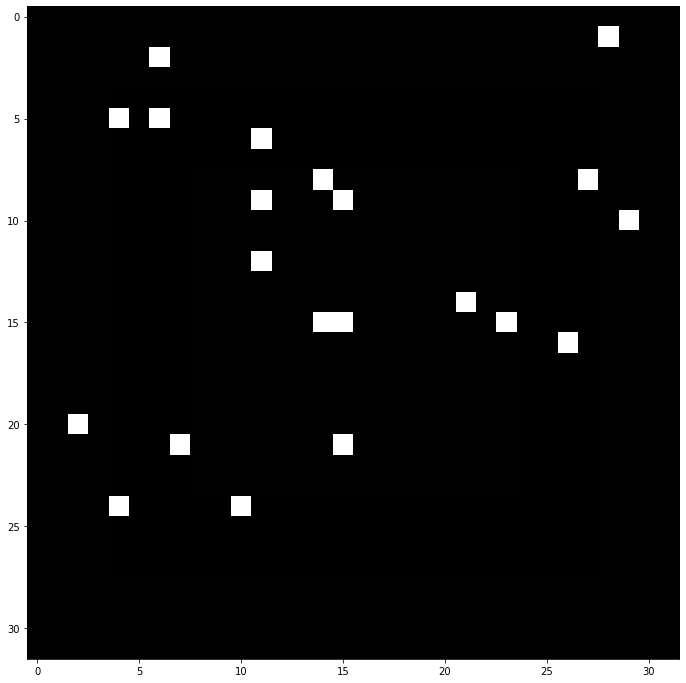

In [131]:
fig, axs = plt.subplots(1,1,figsize=(12,12))
axs.imshow(test_img, cmap=plt.cm.gray)

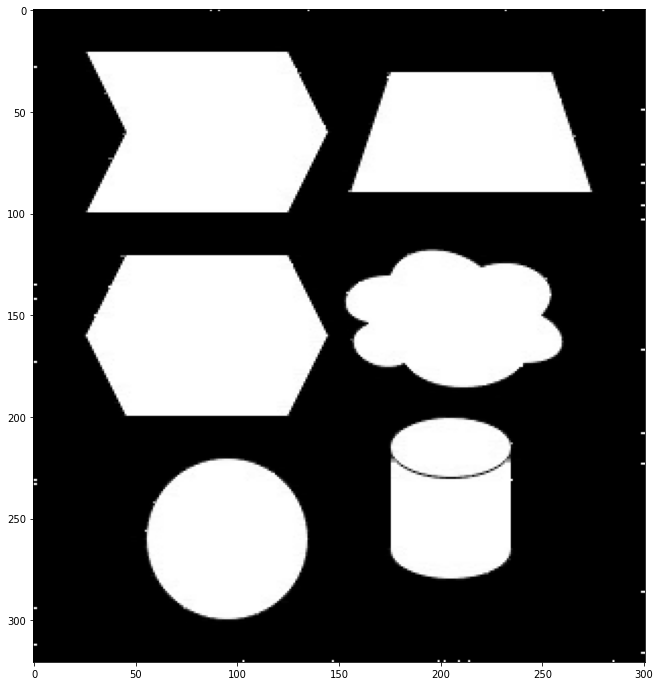

In [129]:
test_image_filtered = opening(test_img, np.ones((3,3),dtype=np.uint8))
fig, axs = plt.subplots(1,1,figsize=(12,12))
axs.imshow(test_image_filtered, cmap=plt.cm.gray)

In [127]:
custom_metric(test_img, img)

0.013630577203713478

In [126]:
custom_metric(img, test_image_filtered)

0.03990850850229246

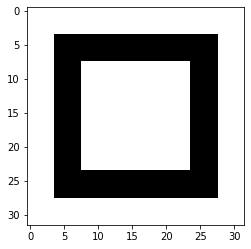

In [137]:
example = figure
plt.imshow(example,cmap=plt.cm.gray)

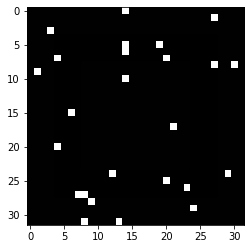

In [140]:
example_noisy = sp(example, 1)
plt.imshow(example_noisy,cmap=plt.cm.gray)

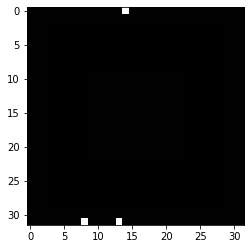

In [143]:
example_erosian = erosian(example_noisy, structs['rect3'])
plt.imshow(example_erosian,cmap=plt.cm.gray)

In [144]:
custom_metric(example, example_noisy)

0.0244140625

In [145]:
custom_metric(example, example_erosian)

0.1591796875

In [149]:
import random

In [150]:
def add_noise(img):
  
    # Getting the dimensions of the image
    row , col = img.shape
      
    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):
        
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
          
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
          
        # Color that pixel to white
        img[y_coord][x_coord] = 255
          
    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):
        
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
          
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
          
        # Color that pixel to black
        img[y_coord][x_coord] = 0
          
    return img

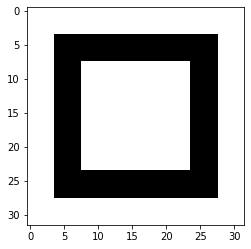

In [147]:
plt.imshow(figure, cmap=plt.cm.gray)

In [154]:
noise_figure = sp(figure, 1)

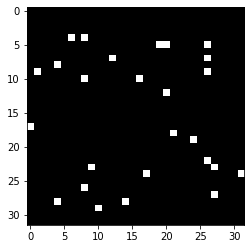

In [155]:
plt.imshow(noise_figure, cmap=plt.cm.gray)